In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [5]:
import rocchio as r

In [138]:
import json
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
qrels_nist = r.read_qrels('eval/RTS17/eval_qrelsfile', 'NIST')

In [8]:
qrels_mobile = qrels_nist.copy()
qrels_mobile.name = 'Mobile'
qrels_mobile.update(r.read_qrels('eval/RTS17/gundog/feedback/mobile-majority.txt', 'Mobile'))

In [9]:
qrels_mobile_equivalence = qrels_nist.copy()
qrels_mobile_equivalence.name = 'Mobile equivalence'
qrels_mobile_equivalence.update(
    r.read_qrels('eval/RTS17/gundog/feedback/equivalence-mobile-majority.txt', 'Mobile equivalence')
)

In [10]:
point_nist = r.read_point(
    'ngram-length(3)_spam-filter(none)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(nist).point'
)

In [11]:
point_default = point_nist.copy()

point_default[
    [
        'Distance to query', 'Distance to positive', 'Distance to negative', 'Score', 'Possible feedback',
    ]
] = np.nan
point_default[['Positive', 'Negative']] = 0
point_default['retrieve'] = False

In [12]:
point_mobile = r.read_point(
    'ngram-length(3)_spam-filter(none)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(mobile-majority).point',
    point_default=point_default,
)

In [326]:
point_mobile_basic_spam = r.read_point(
    'ngram-length(3)_spam-filter(basic)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(mobile-majority).point',
    point_default=point_default,
)    

In [13]:
point_mobile_equivalence = r.read_point(
    'ngram-length(3)_spam-filter(none)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(equivalence-mobile-majority).point',
    point_default=point_default,
)

In [14]:
point_feedback_exact = r.read_point(
    'ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist)_pattern-mode(exact)_spam-filter(none).point',
    point_default=point_default,
)

In [327]:
point_feedback_exact_basic_spam = r.read_point(
    'ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist)_pattern-mode(exact)_spam-filter(basic).point',
    point_default=point_default,
)   

In [15]:
point_feedback_exact_equivalence = r.read_point(
    'ngram-length(3)_feedback-pattern(equivalence-mobile-majority)_feedback(nist)_pattern-mode(exact)_spam-filter(none).point',
    point_default=point_default,
)

In [16]:
point_feedback_amount = r.read_point(
    'ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist)_pattern-mode(amount)_spam-filter(none).point',
    point_default=point_default,
)

In [328]:
point_feedback_amount_basic_spam = r.read_point(
    'ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist)_pattern-mode(amount)_spam-filter(basic).point',
    point_default=point_default,
)

In [17]:
point_feedback_amount_equivalence = r.read_point(
    'ngram-length(3)_feedback-pattern(equivalence-mobile-majority)_feedback(nist)_pattern-mode(amount)_spam-filter(none).point',
    point_default=point_default,
)

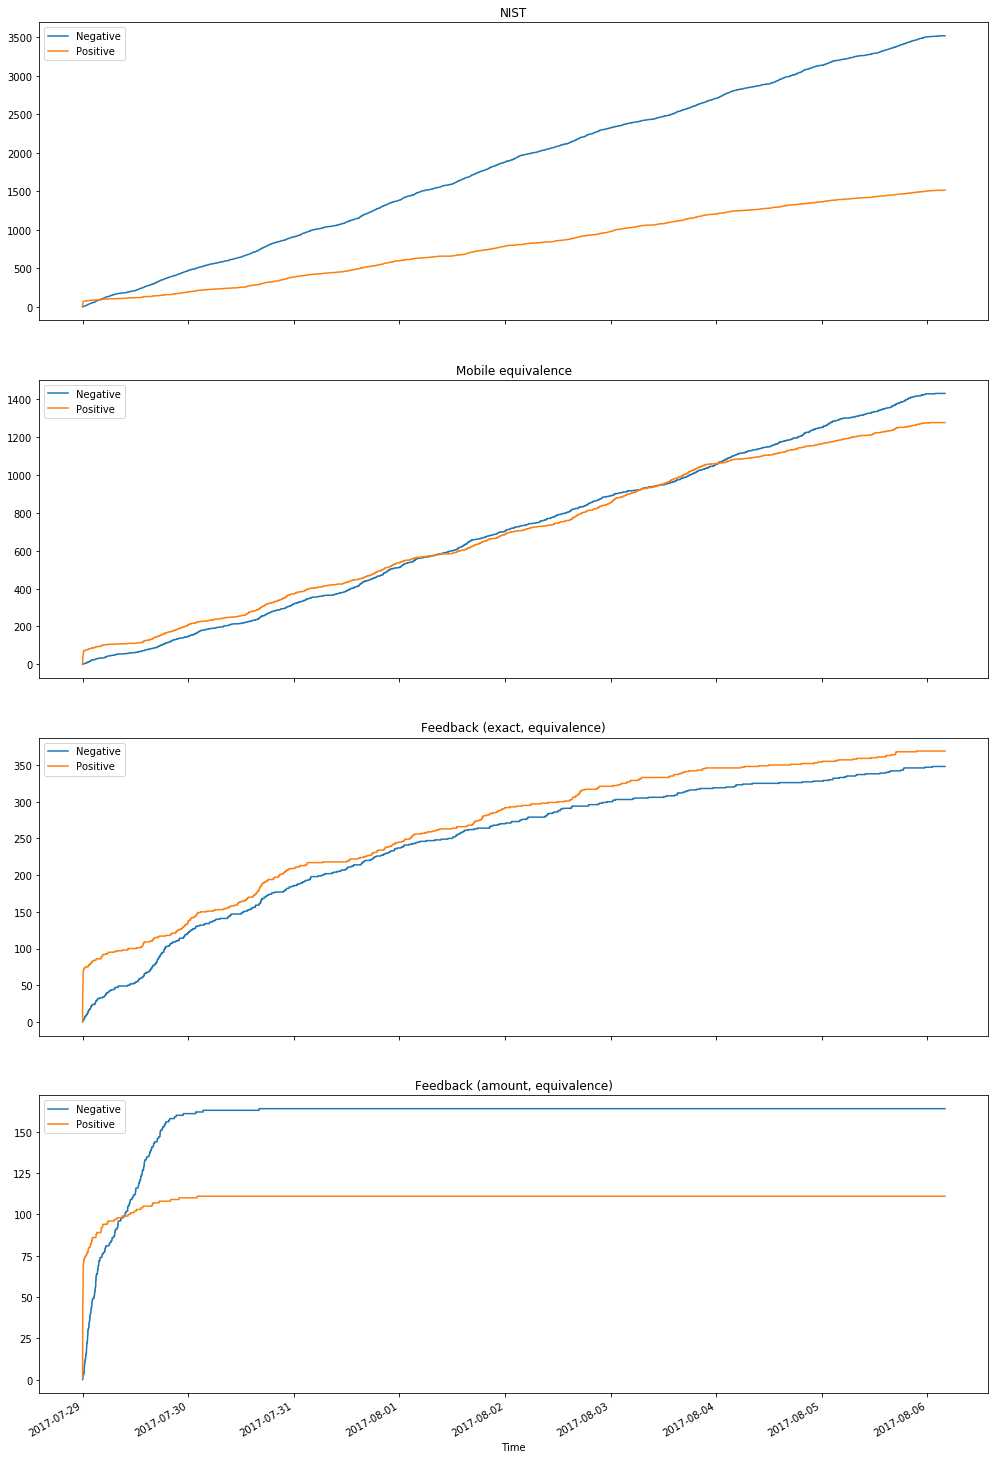

In [331]:
_to_plot = [
    (point_nist, 'NIST'),
#     (point_mobile, 'Mobile'),
#     (point_mobile_basic_spam, 'Mobile basic spam filter'),
    (point_mobile_equivalence, 'Mobile equivalence'),
#     (point_feedback_exact, 'Feedback (exact)'),
#     (point_feedback_exact_basic_spam, 'Feedback(exact, basic spam filter)'),
    (point_feedback_exact_equivalence, 'Feedback (exact, equivalence)'),
#     (point_feedback_amount, 'Feedback (amount)'),
#     (point_feedback_amount_basic_spam, 'Feedback (amount basic spam filter)'),
    (point_feedback_amount_equivalence, 'Feedback (amount, equivalence)'),
]

fig, axs = plt.subplots(len(_to_plot), sharex=True, figsize=(17, 7 * len(_to_plot)))

for ax, (point, title) in zip(axs, _to_plot):
    r.plot_feedback(point, ax=ax, title=title)

In [19]:
evaluation_nist = r.evaluate(point_nist, qrels_nist)

In [20]:
evaluation_mobile = r.evaluate(point_mobile, qrels_mobile)

In [21]:
evaluation_mobile_equivalence = r.evaluate(point_mobile_equivalence, qrels_mobile_equivalence)

In [22]:
evaluation_feedback_exact = r.evaluate(point_feedback_exact, qrels_mobile)

In [23]:
evaluation_feedback_exact_equivalence = r.evaluate(point_feedback_exact_equivalence, qrels_mobile_equivalence)

In [24]:
evaluation_feedback_amount = r.evaluate(point_feedback_amount, qrels_mobile)

In [25]:
evaluation_feedback_amount_equivalence = r.evaluate(point_feedback_amount_equivalence, qrels_mobile_equivalence)

In [26]:
_to_plot = [
    (evaluation_nist, 'NIST'),
    (evaluation_mobile, 'Mobile'),
    (evaluation_mobile_equivalence, 'Mobile equivalence'),
    (evaluation_feedback_exact, 'Feedback (exact)'),
    (evaluation_feedback_exact_equivalence, 'Feedback (exact, equivalence)'),
    (evaluation_feedback_amount, 'Feedback (amount)'),
    (evaluation_feedback_amount_equivalence, 'Feedback (amount, equivalence)'),
]

# fig, axs = plt.subplots(len(_to_plot), sharex=True, figsize=(17, 6 * len(_to_plot)))

evaluation_over_time = None
for evaluation, title in _to_plot:
    e = r.evaluation_over_time(evaluation, ax=ax, title=title)
    
    e.columns = pd.MultiIndex.from_product([e.columns, [title]])

    if evaluation_over_time is None:
        evaluation_over_time = e
    else:
        evaluation_over_time = evaluation_over_time.merge(e, left_index=True, right_index=True, how='outer')

In [27]:
evaluation_over_time[
    [
#         'TP', 'TN', 'FP', 'FN',
        'ScoreTP', 'ScoreTN', 'ScoreFP', 'ScoreFN',
    ]
].groupby(axis='columns', level=1).sum().max()

Feedback (amount)                  631
Feedback (amount, equivalence)     761
Feedback (exact)                   864
Feedback (exact, equivalence)     1119
Mobile                            1168
Mobile equivalence                1436
NIST                              3626
dtype: int64

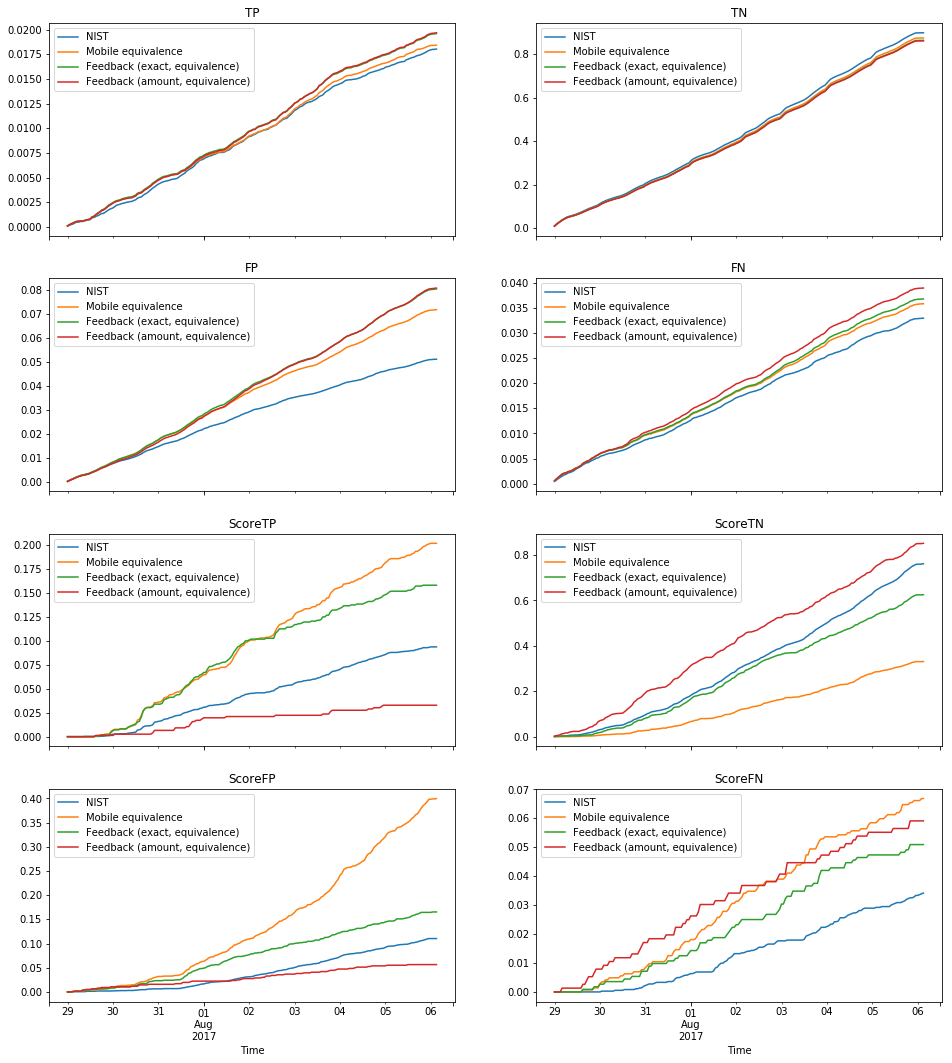

In [28]:
_to_plot = [
    ['TP', 'TN'],
    ['FP', 'FN'],
    ['ScoreTP', 'ScoreTN'],
    ['ScoreFP', 'ScoreFN'],
#     ['Not evaluated'],
]

fig, axs = plt.subplots(len(_to_plot), 2, sharex=True, figsize=(16, 4.5 * len(_to_plot)))

for what_, axs_ in zip(_to_plot, axs):
    for what, ax in zip(what_, axs_):
        
        if what.startswith('S'):
            _ = ['ScoreTP', 'ScoreTN', 'ScoreFP', 'ScoreFN']
        else:
            _ = ['TP', 'TN', 'FP', 'FN']
        N = evaluation_over_time[_].groupby(axis='columns', level=1).sum().max()
        
        if what:
            (
                evaluation_over_time[what]
#                 / evaluation_over_time[what].max()
#                 / evaluation_over_time.groupby(axis='columns', level=1).sum().max()
                / N
            )[
                [
                    'NIST',
#                     'Mobile',
                    'Mobile equivalence',
#                     'Feedback (exact)',
                    'Feedback (exact, equivalence)',
#                     'Feedback (amount)',
                    'Feedback (amount, equivalence)',
                ]
            ].plot(ax=ax, title=what)

In [ ]:
r.plot_evaluation(evaluation_nist);

In [ ]:
r.plot_evaluation(evaluation_mobile);

In [ ]:
r.plot_evaluation(evaluation_mobile_equivalence);

In [ ]:
r.plot_evaluation(evaluation_feedback_exact);

In [ ]:
r.plot_evaluation(evaluation_feedback_amount);

In [120]:
_selection = (
    [
        'TP', 'TN', 'FP', 'FN',
        'ScoreTP', 'ScoreTN', 'ScoreFP', 'ScoreFN',
    ],
    [
#         'TP', 'TN', 'FP', 'FN',
        'ScoreTP', 'ScoreTN', 'ScoreFP', 'ScoreFN',
    ]
)

_ = pd.DataFrame(
    {
        'NIST': evaluation_nist['Evaluation'],
        'Mobile equivalence': evaluation_mobile_equivalence['Evaluation'],
     }
)

nist_me = _.groupby(['NIST', 'Mobile equivalence']).size().unstack(fill_value=0).loc[_selection]

nit_me_by_topic = (
    _.reset_index('Topic').groupby(['NIST', 'Mobile equivalence', 'Topic']).size()
    .unstack('Mobile equivalence', fill_value=0).loc[_selection]
)

tweet_nist_me_kind = _

In [333]:
nit_me_by_topic.loc['TN', 'ScoreFP'].sort_values(ascending=False).head(12)

Topic
RTS190    33
RTS73     32
RTS114    28
RTS58     23
RTS62     17
RTS162    15
RTS156    14
RTS153    13
RTS136    13
RTS113    12
RTS98     12
RTS91     11
Name: ScoreFP, dtype: int64

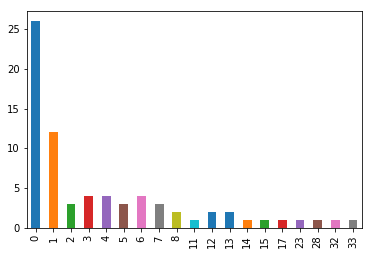

In [106]:
(
    nit_me_by_topic.loc['TN', 'ScoreFP']
    .value_counts().sort_index()
    .plot.bar()
);

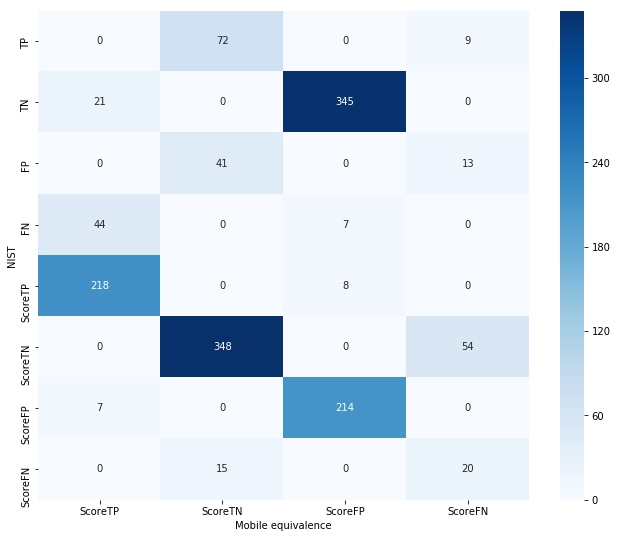

In [96]:
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(nist_me, annot=True, fmt='d', cmap='Blues', ax=ax);

In [111]:
extended_mobile = (
    'eval/RTS17/gundog/point/ngram-length(3)_spam-filter(none)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(equivalence-mobile-majority).point.jsonl'
)

In [230]:
def records(f_name, kind ,nist_kind='TN', mobile_kind='ScoreFP'):
    with open(f_name) as f:
        for line in f:
            data = json.loads(line)

            _mobile, _nist = kind.loc[data['tweet_id'], data['topid']].values
            if  _nist == 'TN' and _mobile == 'ScoreFP':
                min_positive = min((s for _, s in data['positive_ids_distances']), default=None)
                for p_tid, score in data['positive_ids_distances']:
                    if score == min_positive:
                        yield data['topid'], data['tweet_id'], 'positive', p_tid, score

                min_negative = min((s for _, s in data['negative_ids_distances']), default=None)
                for n_tid, score in data['negative_ids_distances']:
                    if score == min_negative:
                        yield data['topid'], data['tweet_id'], 'negative', n_tid, score

In [276]:
pos_neg_ids = (
    pd.DataFrame
    .from_records(
        itertools.islice(records(extended_mobile, tweet_nist_me_kind), None),
        columns=['Topic', 'target_tweet_id', 'feedback', 'tweet_id', 'score'],
    )
    .sort_values(['tweet_id', 'Topic', 'feedback'])
    .set_index(['tweet_id', 'Topic'])
)

pos_neg_ids['NIST'] = evaluation_nist['relevant'][pos_neg_ids.index]
pos_neg_ids['Mobile equivalence'] = evaluation_mobile_equivalence['relevant'][pos_neg_ids.index]

In [289]:
score_source = (
    pos_neg_ids
    .reset_index()
    .sort_values(['target_tweet_id', 'Topic', 'feedback'])
    .set_index(['target_tweet_id', 'Topic', 'feedback'])    
)

In [318]:
influencers = score_source.loc[
    (score_source['NIST'] != score_source['Mobile equivalence'])
    & ~score_source['Mobile equivalence'].isna()
    & ~score_source['NIST'].isna()
].reset_index().set_index(
    [
        'tweet_id', 'Topic',
        'target_tweet_id', 'feedback',
    ]
).sort_index()

influencers_size = influencers.groupby(level=['tweet_id', 'Topic']).size().sort_values(ascending=False)
influencers_size.head()

tweet_id            Topic 
892028619605905408  RTS114    18
891841608169263104  RTS156    14
892906692937224192  RTS73     13
893022048901107712  RTS58     13
891354875967270912  RTS190    10
dtype: int64

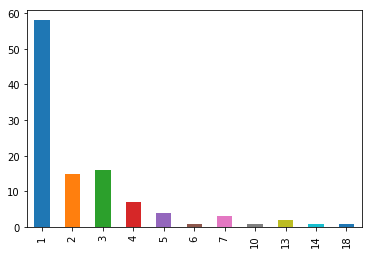

In [325]:
influencers_size.value_counts().sort_index().plot.bar();

In [296]:
influencers.loc[892028619605905408, 'RTS114']

,,score,NIST,Mobile equivalence
target_tweet_id,feedback,,,
892038241330843648,positive,0.663752,0.0,1.0
892093740386443264,positive,0.751990,0.0,1.0
892120827168206848,positive,0.789147,0.0,1.0
892265811712323584,positive,0.782215,0.0,1.0
892268068214378497,positive,0.788454,0.0,1.0
892272161850830849,positive,0.773335,0.0,1.0
892391884097638400,positive,0.640712,0.0,1.0
892415850325696512,positive,0.765958,0.0,1.0
892449882903953408,positive,0.777710,0.0,1.0


In [312]:
%%html

<div id="source-tweet">
<script src="//platform.twitter.com/widgets.js"></script>
<script>twttr.widgets.createTweet("892028619605905408", document.getElementById("source-tweet"));</script>

In [314]:
%%html

<div id="target-tweet">
<script src="//platform.twitter.com/widgets.js"></script>
<script>twttr.widgets.createTweet("892038241330843648", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892093740386443264", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892120827168206848", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892265811712323584", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892268068214378497", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892272161850830849", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892391884097638400", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892415850325696512", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892449882903953408", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("892733803743125504", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893222830233366528", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893268296480501761", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893282510976802816", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893538627761909761", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893564225590886401", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893656164768112641", document.getElementById("target-tweet"));</script>
<script>twttr.widgets.createTweet("893958519522828288", document.getElementById("target-tweet"));</script>

In [315]:
influencers.loc[891841608169263104, 'RTS156']

,,score,NIST,Mobile equivalence
target_tweet_id,feedback,,,
892384380492144642,positive,0.752581,0.0,1.0
892583190463905792,positive,0.788408,0.0,1.0
892715189430349824,positive,0.787242,0.0,1.0
892746751576342528,positive,0.743091,0.0,1.0
892761607792713728,positive,0.700785,0.0,1.0
892776044599668737,positive,0.768792,0.0,1.0
892945905506299904,positive,0.760571,0.0,1.0
893074943277232128,positive,0.757374,0.0,1.0
893107600119795712,positive,0.748566,0.0,1.0


In [316]:
%%html

<div id="source-tweetRTS156">
<script src="//platform.twitter.com/widgets.js"></script>
<script>twttr.widgets.createTweet("891841608169263104", document.getElementById("source-tweetRTS156"));</script>

In [317]:
%%html

<div id="target-tweetRTS156">
<script src="//platform.twitter.com/widgets.js"></script>
<script>twttr.widgets.createTweet("892384380492144642", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("892583190463905792", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("892715189430349824", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("892746751576342528", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("892761607792713728", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("892776044599668737", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("892945905506299904", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893074943277232128", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893107600119795712", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893231764100874241", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893441454147854336", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893723361704062976", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893791389124841472", document.getElementById("target-tweetRTS156"));</script>
<script>twttr.widgets.createTweet("893835253160304640", document.getElementById("target-tweetRTS156"));</script>

In [235]:
evaluation_nist.loc[891210591905382400, 'RTS127']

Time                 2017-07-29 08:15:37
Distance to query               0.989942
Score                            1.03021
retrieve                           False
retrieve_query                     False
relevant                               0
Evaluation                            TN
Name: (891210591905382400, RTS127), dtype: object

In [236]:
evaluation_mobile_equivalence.loc[891210591905382400, 'RTS127']

Time                 2017-07-29 08:15:37
Distance to query               0.989942
Score                           0.991937
retrieve                            True
retrieve_query                     False
relevant                               0
Evaluation                       ScoreFP
Name: (891210591905382400, RTS127), dtype: object

In [ ]:
effect = by_topic.groupby(['Topic', 'Kind']).size().unstack('Kind').fillna(0)

In [ ]:
total_effect = effect['ScoreTP'] + effect['ScoreTN'] + effect['ScoreFP'] + effect['ScoreFN']

total_effect.plot.hist();

In [ ]:
pd.concat(
    [
        total_effect.sort_values(ascending=False).head(10),
#         total_effect.sort_values(ascending=False).tail(),
    ]
)

In [ ]:
for what, judgment in [
    ('Error', 'Relevance'),
    ('Error (NIST)', 'NIST'),
    ('Error (Mobile)', 'Mobile'),
]:
    by_topic[what] = by_topic.apply(
        lambda r: {
            (True, True, True): 'TP',
            (True, True, False): 'FP',
            (False, False, True): 'FN',
            (False, False, False): 'TP',        

            (True, False, True): 'TN',
            (True, False, False): 'FN',
            (False, True, True): 'TP',
            (False, True, False): 'FP',
        }.get(tuple(r.loc[['retrieve_query', 'retrieve', judgment]].values)),
        axis='columns',
    )

In [ ]:
for what in 'Error', 'Error (NIST)', 'Error (Mobile)':
    _ = by_topic.groupby(['Topic', what]).size().unstack(what).fillna(0)

    _bs = 1 ** 2
    FP = point['retrieve'].sum(axis='rows') -_.TP
    _['F'] = ((1 + _bs) * _.TP) / ((1 + _bs) * _.TP + _bs * _.FN + FP)

#     _['F'].plot.hist()

    print('F (avg per topic, {}): {:0.2f}'.format(what, _.F.mean()))

In [ ]:
for what in 'Error', 'Error (NIST)', 'Error (Mobile)':
    _ = by_topic.groupby(what).size()

    _bs = 1 ** 2
    FP = (point['retrieve'] == True).sum().sum() -_.TP
    print(
        'F (over all topics, {}): {:0.2f}'.format(
            what,
            ((1 + _bs) * _.TP) / ((1 + _bs) * _.TP + _bs * _.FN + FP)
        )
    )

In [ ]:
_ = pd.DataFrame(list(qrels_nist.align(qrels_mobile))).T

with open('eval/RTS17/gundog/topic-filter.txt') as f:
    topic_filter = set(l.strip() for l in f)

_ = _[_['NIST'].isna()].reset_index('topic').groupby('topic').size()[topic_filter].sort_values(ascending=False)

_.plot.hist();

_.head(20)

In [ ]:
# (
#     by_topic.loc[
#         (by_topic['Distance to query'] <= 0.8) & (by_topic['retrieve'] == False),
#         ['Topic', 'Relevance']
#     ]
# ).groupby(['Topic', 'Relevance']).size().unstack('Relevance').sort_values(
#     False, # Most improved recall
# #     True, # Most deteriorated recall
#     ascending=False
# ).head()

In [ ]:
# (
#     by_topic.loc[
#         (by_topic['Distance to query'] > 0.8) & (by_topic['retrieve'] == True),
#         ['Topic', 'Relevance']
#     ]
# ).groupby(['Topic', 'Relevance']).size().unstack('Relevance').sort_values(
# #     True, # Most improved precision
#     False, # Most deteriorated precision
#     ascending=False
# ).head()

In [ ]:
# _ = by_topic.groupby('Topic').apply(lambda df: df['Relevance'].value_counts()).unstack(1)
# _['Total'] = _.sum(axis='columns')
# _['True to False']  = _[True] / _[False]
# _.sort_values('True to False', inplace=True, ascending=False)
# _.head(10)

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS212'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS48'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS207'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS94'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS47'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# (
#     point
# #     .sort_values(
# #         [
# #     #             ('Relevance', 'RTS212'),
# #                 ('Distance to query', 'RTS212'),
# #     #             ('Distance to query', 'RTS48'),
# #     #             ('Score', 'RTS212'),
# #     #             ('Score', 'RTS48'),
# #     #             ('Relevance', 'RTS212'),
# #     #             ('Relevance', 'RTS48'),
# #         ],
# #         ascending=True,
# #     )
#     [
#         [
#             ('Distance to query', 'RTS212'),
#             ('Score', 'RTS212'),
#             ('retrieve', 'RTS212'),
#             ('Relevance', 'RTS212'),
#             ('Distance to positive', 'RTS212'),
#             ('Distance to negative', 'RTS212'),
#             ('Positive', 'RTS212'),
#             ('Negative', 'RTS212'),
#         ]
#     ]
#     .dropna(subset=[('Relevance', 'RTS212')], axis='rows', how='any')
# )

In [ ]:
# distance_score = (
#     point[['Distance to query', 'Score', 'Relevance', 'retrieve']]
#     .stack(['Topic'])
#     .set_index(['retrieve'] , append=True)
#     .dropna(subset=['Relevance'])
#     .set_index('Relevance', append=True)
#     .stack().to_frame('Value')
#     .reset_index()
#     .set_index(['Topic', 'tweet_id'])
# )
# distance_score = distance_score[distance_score['Relevance'] >= 0]
# distance_score['Relevance'] = distance_score['Relevance'] > 0

# # distance_score.loc[:, 'Value'] = 1 / (1 + np.exp(-distance_score['Value']))

# distance_score.loc[distance_score['Relevance'] > 0, 'Relevance'] = 'Relevant'
# distance_score.loc[distance_score['Relevance'] == 0, 'Relevance'] = 'Non-relevant'

# distance_score['Error'] = distance_score.apply(
#     lambda r: {
#         ('Relevant', True): 'TP',
#         ('Relevant', False): 'FN',
#         ('Non-relevant', True): 'FP',
#         ('Non-relevant', False): 'TN',
#     }[r['Relevance'], r['retrieve'] if r['Variable'] == 'Score' else r['Value'] < 0.8],
#     axis='columns',
# )

In [ ]:
# sns.swarmplot(
#     distance_score.reset_index().set_index('Variable')
#     .loc['Score', ['Topic', 'Relevance']]
#     .reset_index()
#     .groupby(['Topic', 'Relevance'])
#     .size(),
# #     .unstack('Topic')
#     dodge=True,
# );

In [ ]:
# !mkdir -p eval/RTS17/plots/

In [ ]:
# f, ax = plt.subplots(figsize=(14, 7))

# sns.violinplot(
#     data=distance_score, x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'], dodge=True,
#     ax=ax,
# );

# f.savefig('eval/RTS17/plots/distance-score-comparison.pdf')

In [ ]:
# f, ax = plt.subplots(figsize=(14, 7))

# sns.swarmplot(
#     data=distance_score, x='Variable', y='Value', hue='Error',
#     hue_order=[
#         'FN', 'FP', 'TN', 'TP',
#     ],
#     palette={
#         'FN': 'r',
#         'TN': 'g',
#         'FP': 'r',
#         'TP': 'g',
#         'N': 'r',
#         'P': 'g',
#     },
#     dodge=True,
#     ax=ax,
# );

# f.savefig('eval/RTS17/plots/distance-score-comparison-error-type.pdf')

# Mobile asessor agreement over time

In [ ]:
mobile = pd.read_csv(
    'eval/RTS17/qrels-crowd',
    sep='\s+',
    header=None,
    names=['Topic', 'Assessor', 'tweet_id', 'Judgment', 'timestampe'],
    index_col=['Topic', 'tweet_id'],
)

In [ ]:
mobile_judgment = (
    mobile['Judgment']
    .groupby(level=['Topic', 'tweet_id'])
    .value_counts()
    .unstack('Judgment')
    [[0, 1, 2]]
    .fillna(0)
)

In [ ]:
mobile_judgment['Disagreement'] = mobile_judgment.max(axis='columns') != mobile_judgment.sum(axis='columns')

In [ ]:
disagreement = (
    mobile_judgment
    .sort_index()
    [['Disagreement']]
#     .unstack('Topic')
#     .fillna(0)
#     .cumsum(axis='rows')
#     .sum(axis='columns')
#     .plot(use_index=False)
);

In [ ]:
disagreement['position'] = disagreement.groupby(level=['Topic']).cumcount()
disagreement['disagreements'] = disagreement['Disagreement'].groupby(level=['Topic']).cumsum()

In [ ]:
(
    disagreement.loc[
        (disagreement['Disagreement'] & disagreement['disagreements'] == 1),
        'position'
    ]
    .groupby(level=['Topic']).first()
    .value_counts()
#     .sort_values(ascending=False)
    .sort_index()
#     .head(20)
    .plot(kind='bar', figsize=(14,7))
);

In [ ]:
# mobile_judgment.loc['RTS151']